In [ ]:
import math
import random
import time
import multiprocessing as mp
from functools import partial
import urllib.request
import os
import matplotlib.pyplot as plt


In [ ]:
def download_tsplib(url: str, local_name: str | None = None) -> str:
    if local_name is None:
        local_name = url.split("/")[-1]
    print(f"Pobieram {url} -> {local_name}")
    urllib.request.urlretrieve(url, local_name)
    return local_name

def load_tsplib_coords(filename: str):
    coords = []
    with open(filename, 'r') as f:
        in_node_section = False
        for line in f:
            line = line.strip()
            if line == "NODE_COORD_SECTION":
                in_node_section = True
                continue
            if line == "EOF":
                break
            if in_node_section:
                parts = line.split()
                if len(parts) >= 3:
                    x = float(parts[1])
                    y = float(parts[2])
                    coords.append((x, y))
    return coords

class TSPInstance:
    def __init__(self, coords):
        self.coords = coords
        self.n_cities = len(coords)
        self.dist_matrix = [[0.0]*self.n_cities for _ in range(self.n_cities)]
        for i in range(self.n_cities):
            for j in range(self.n_cities):
                if i != j:
                    # math.dist jest ok, ewentualnie sqrt ręcznie
                    self.dist_matrix[i][j] = math.dist(coords[i], coords[j])

    def tour_length(self, tour):
        total = 0.0
        for i in range(len(tour)):
            a = tour[i]
            b = tour[(i + 1) % len(tour)]
            total += self.dist_matrix[a][b]
        return total

    def random_tour(self):
        tour = list(range(self.n_cities))
        random.shuffle(tour)
        return tour

def create_tsp_instance_from_url(url: str) -> TSPInstance:
    fname = download_tsplib(url)
    coords = load_tsplib_coords(fname)
    instance = TSPInstance(coords)
    print("Liczba miast:", instance.n_cities)
    return instance


In [ ]:
# PRZYKŁAD 1: berlin52
TSPLIB_URL = "https://raw.githubusercontent.com/mastqe/tsplib/master/kroA150.tsp"
instance = create_tsp_instance_from_url(TSPLIB_URL)


Pobieram https://raw.githubusercontent.com/mastqe/tsplib/master/kroA150.tsp -> kroA150.tsp
Liczba miast: 150


In [ ]:
def init_population(instance: TSPInstance, pop_size: int):
    return [instance.random_tour() for _ in range(pop_size)]

def tournament_selection(population, fitness, tournament_size=3):
    best_idx = None
    for _ in range(tournament_size):
        i = random.randrange(len(population))
        if best_idx is None or fitness[i] < fitness[best_idx]:
            best_idx = i
    return best_idx

def order_crossover(parent1, parent2):
    size = len(parent1)
    a, b = sorted(random.sample(range(size), 2))
    child = [None] * size
    child[a:b+1] = parent1[a:b+1]
    p2_genes = [g for g in parent2 if g not in child]
    idx = 0
    for i in range(size):
        if child[i] is None:
            child[i] = p2_genes[idx]
            idx += 1
    return child

def crossover_pair(parents):
    parent1, parent2 = parents
    if parent1 == parent2:
        return parent1[:], parent2[:]
    child1 = order_crossover(parent1, parent2)
    child2 = order_crossover(parent2, parent1)
    return child1, child2

def mutate_swap(tour, mutation_rate=0.02):
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(tour)), 2)
        tour[i], tour[j] = tour[j], tour[i]
    return tour


In [ ]:
def evaluate_population_sequential(instance: TSPInstance, population):
    return [instance.tour_length(ind) for ind in population]

def genetic_algorithm_sequential(
    instance: TSPInstance,
    pop_size=200,
    generations=500,
    crossover_rate=0.9,
    mutation_rate=0.02,
    tournament_size=3,
):
    population = init_population(instance, pop_size)
    best_lengths = []
    best_individual = None
    best_length = float("inf")

    start = time.perf_counter()

    for gen in range(generations):
        fitness = evaluate_population_sequential(instance, population)

        # najlepszy osobnik
        for ind, fit in zip(population, fitness):
            if fit < best_length:
                best_length = fit
                best_individual = ind[:]

        best_lengths.append(best_length)

        # selekcja rodziców
        parents = []
        while len(parents) < pop_size:
            idx = tournament_selection(population, fitness, tournament_size)
            parents.append(population[idx])

        # krzyżowanie + mutacja
        children = []
        for i in range(0, pop_size, 2):
            p1 = parents[i]
            p2 = parents[(i + 1) % pop_size]
            if random.random() < crossover_rate:
                c1, c2 = crossover_pair((p1, p2))
            else:
                c1, c2 = p1[:], p2[:]
            children.append(mutate_swap(c1, mutation_rate))
            children.append(mutate_swap(c2, mutation_rate))

        population = children[:pop_size]

    end = time.perf_counter()
    elapsed = end - start
    return best_individual, best_length, best_lengths, elapsed

# test
best_ind_seq, best_len_seq, curve_seq, time_seq = genetic_algorithm_sequential(
    instance,
    pop_size=200,
    generations=200
)
print("SEQ: najlepsza długość:", best_len_seq, "czas [s]:", time_seq)
def evaluate_population_sequential(instance: TSPInstance, population):
    return [instance.tour_length(ind) for ind in population]



SEQ: najlepsza długość: 103615.28678581196 czas [s]: 10.328989547000674
SEQ: najlepsza długość: 104946.73610544078 czas [s]: 10.872383855000407


In [ ]:
# Globalna zmienna dostępna w procesach potomnych
GLOBAL_INSTANCE = None

def init_pool_fitness(instance: TSPInstance):
    global GLOBAL_INSTANCE
    GLOBAL_INSTANCE = instance

def evaluate_individual(tour):
    # używamy GLOBAL_INSTANCE.tour_length
    return GLOBAL_INSTANCE.tour_length(tour)
def evaluate_population_parallel(population, pool, chunk_size=8):
    fitness = pool.map(evaluate_individual, population, chunksize=chunk_size)
    return fitness

def genetic_algorithm_parallel_fitness(
    instance: TSPInstance,
    pop_size=200,
    generations=500,
    crossover_rate=0.9,
    mutation_rate=0.02,
    tournament_size=3,
    n_jobs=None,
    chunk_size=8,
):
    if n_jobs is None:
        n_jobs = mp.cpu_count()

    population = init_population(instance, pop_size)
    best_lengths = []
    best_individual = None
    best_length = float("inf")

    start = time.perf_counter()

    # Pula procesów
    with mp.Pool(processes=n_jobs, initializer=init_pool_fitness, initargs=(instance,)) as pool:
        for gen in range(generations):

            fitness = evaluate_population_parallel(population, pool, chunk_size)

            # najlepszy osobnik
            for ind, fit in zip(population, fitness):
                if fit < best_length:
                    best_length = fit
                    best_individual = ind[:]

            best_lengths.append(best_length)

            # selekcja rodziców
            parents = []
            while len(parents) < pop_size:
                idx = tournament_selection(population, fitness, tournament_size)
                parents.append(population[idx])

            # krzyżowanie + mutacja
            children = []
            for i in range(0, pop_size, 2):
                p1 = parents[i]
                p2 = parents[(i + 1) % pop_size]
                if random.random() < crossover_rate:
                    c1, c2 = crossover_pair((p1, p2))
                else:
                    c1, c2 = p1[:], p2[:]
                children.append(mutate_swap(c1, mutation_rate))
                children.append(mutate_swap(c2, mutation_rate))

            population = children[:pop_size]

    end = time.perf_counter()
    elapsed = end - start
    return best_individual, best_length, best_lengths, elapsed


NameError: name 'TSPInstance' is not defined

In [ ]:
if __name__ == "__main__":
    POP_SIZE = 200      # 400, 800
    GENERATIONS = 300
    N_JOBS = 2

    # sekwencyjny
    best_ind_seq, best_len_seq, curve_seq, time_seq = genetic_algorithm_sequential(
        instance,
        pop_size=POP_SIZE,
        generations=GENERATIONS
    )

    # równoległy fitness
    best_ind_par, best_len_par, curve_par, time_par = genetic_algorithm_parallel_fitness(
        instance,
        pop_size=POP_SIZE,
        generations=GENERATIONS,
        n_jobs=N_JOBS,
        chunk_size=8
    )

    print("=== SEKWENCYJNY ===")
    print("Najlepsza długość:", best_len_seq)
    print("Czas [s]:", time_seq)

    print("\n=== RÓWNOLEGŁY FITNESS ===")
    print("Najlepsza długość:", best_len_par)
    print("Czas [s]:", time_par)

    speedup = time_seq / time_par if time_par > 0 else float("inf")
    print(f"\nPrzyspieszenie (speed-up) ≈ {speedup:.2f}x")


=== SEKWENCYJNY ===
Najlepsza długość: 89335.80543089705
Czas [s]: 14.139581997999812

=== RÓWNOLEGŁY FITNESS ===
Najlepsza długość: 92191.01417153061
Czas [s]: 13.741686908999327

Przyspieszenie (speed-up) ≈ 1.03x


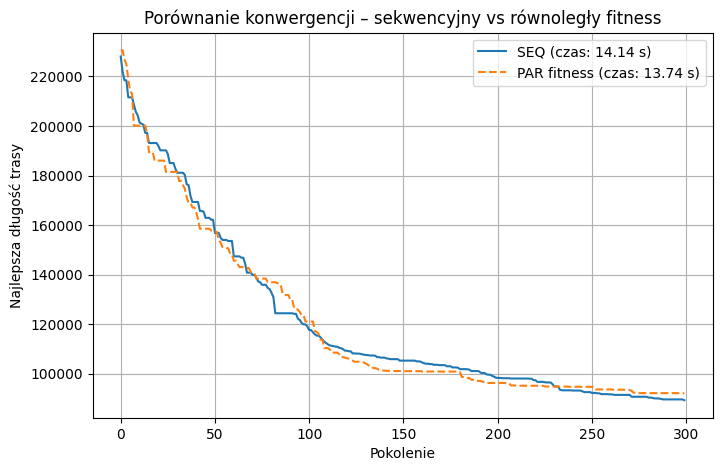

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(curve_seq, label=f"SEQ (czas: {time_seq:.2f} s)")
plt.plot(curve_par, label=f"PAR fitness (czas: {time_par:.2f} s)", linestyle="--")
plt.xlabel("Pokolenie")
plt.ylabel("Najlepsza długość trasy")
plt.title("Porównanie konwergencji – sekwencyjny vs równoległy fitness")
plt.grid(True)
plt.legend()
plt.show()


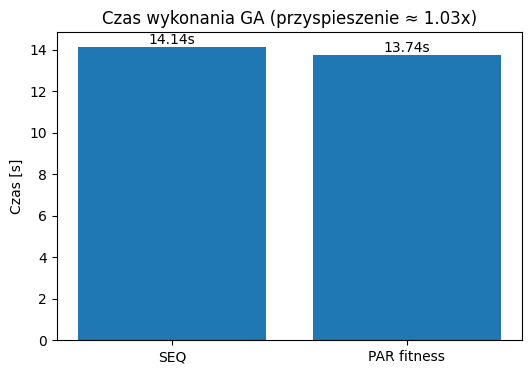

In [ ]:
plt.figure(figsize=(6, 4))
plt.bar(["SEQ", "PAR fitness"], [time_seq, time_par])
plt.ylabel("Czas [s]")
plt.title(f"Czas wykonania GA (przyspieszenie ≈ {speedup:.2f}x)")
for i, v in enumerate([time_seq, time_par]):
    plt.text(i, v, f"{v:.2f}s", ha="center", va="bottom")
plt.show()
